💨# TPS_MAR_2022_TimeSeries⏱🚗🚕🚌🚚🚙💨💨💨

In [ ]:
import numpy as np 
import pandas as pd

from math import sin, cos, pi
import statistics

from itertools import combinations
import itertools

# PLOT
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import matplotlib.pyplot as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'

import plotly.express as px

from cycler import cycler
from IPython import display


import seaborn as sns
%matplotlib inline
sns.set()

# DateTime
from datetime import datetime, date, time
import holidays

from fastai.imports import *
from fastai.tabular.core import *

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Read file
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/test.csv')
sub = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv")

In [ ]:
data_1 = train.copy()
data_2 = test.copy()

In [ ]:
train

* train data begins on Aplil 1 and ends on the morning of September 30.

In [ ]:
test

* The test's row_id is a contination of the train's row_id.
* It's starting this afternoon.

In [ ]:
sub

* submission is congestion results. row_id is the same test id.

In [ ]:
def check(df):
    col_list = df.columns.values
    rows = []
    for col in col_list:
        tmp = (col,
              train[col].dtype,
              train[col].isnull().sum(),
              train[col].count(),
              train[col].nunique(),
              train[col].unique())
        rows.append(tmp)
    df = pd.DataFrame(rows) 
    df.columns = ['feature','dtype','nan','count','nunique','unique']
    return df

check(train)

In [ ]:
def check(df):
    col_list = df.columns.values
    rows = []
    for col in col_list:
        tmp = (col,
              test[col].dtype,
              test[col].isnull().sum(),
              test[col].count(),
              test[col].nunique(),
              test[col].unique())
        rows.append(tmp)
    df = pd.DataFrame(rows) 
    df.columns = ['feature','dtype','nan','count','nunique','unique']
    return df

check(test)

In [ ]:
# US  holidays
for ptr in holidays.US(years = 1991).items():
    print(ptr)

* Holidays between April and September are Memorial Day (5/27Mon), Independence Day(7/4Thr), Labor Day(9/2Mon)
* There will be some traffic restrictions on Memorial Day due to the parade.
* Some congestion is expected at night due to the annual fireworks on independence Day.
* The College's academic year end in May.
* Th end of school year is end of MAy or the first week of June, and also Back to school is end of Augaust or the first week of September. School bus service is suspended in Jun ,July and August. Therefore, it may some affect the congestion.
*  Some people may go out to the mall instead of to work on holidays or weekend.

In [ ]:
def add_holiday_info(df):
    
    make_date(df, 'time')
    us_holidays = []
    for x in holidays.UnitedStates(years=1991).items():
        us_holidays.append(str(x[0]))
    
    df['is_holiday'] = [1 if str(val).split()[0] in us_holidays else 0 for  val in df['time'].dt.date]
    return df

In [ ]:
train = add_holiday_info(train)
test = add_holiday_info(test)

train[720000:720005]

* 👍Seems to be working

===================================
# Distribution

In [ ]:
plt.figure(figsize=(24,12))
axs = train.congestion.value_counts().sort_index().plot.bar(grid=True)
axs.bar_label(axs.containers[0])
plt.axvline(x=train.congestion.mean(),c='red',ls=':',label='Mean')
plt.axvline(x=train.congestion.median(),c='green',ls=':',label='Median')
plt.title("Congestion")
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

===================================
# Trend? Seasonal? Cycle?

In [ ]:
train_daily = train.set_index('time').groupby([pd.Grouper(freq='D')])[['congestion']].mean()
train_daily = train_daily.reset_index()
train_weekly = train.set_index('time').groupby([pd.Grouper(freq='W-MON')])[['congestion']].mean()
train_weekly = train_weekly.reset_index()
train_monthly = train.set_index('time').groupby([pd.Grouper(freq='MS')])[['congestion']].mean()
train_monthly = train_monthly.reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=train_daily, x='time', y='congestion', ax=ax, label='train_daily');
sns.lineplot(data=train_weekly, x='time', y='congestion', ax=ax, label='train_weekly', color = 'red');
sns.lineplot(data=train_monthly, x='time', y='congestion', ax=ax, label='train_monthly', color = 'green');
plt.show()

* I tried to show the avarage congestion at the daily, beginning of the week and beginning of month
* Trend  : a long-term movement, represent an increase or decrease.
* Seasonal : a short-term movement(12month, the day of the week),Remove seasonal factors using the moving-avarage method.
* Cycle: a long-term movement(longer than one year) It has a kind of cyclicality.

==================================
#  Features

In [ ]:
def feature_engineering(data):
    data['time'] = pd.to_datetime(data['time'])
    data['year'] = data.time.dt.year
    data['month'] = data.time.dt.month
    data['week'] = data.time.dt.isocalendar().week
    data['dayofweek'] = data.time.dt.dayofweek 
    #data['weekday'] = data.time.dt.weekday
    data['day'] = data.time.dt.dayofyear
    data['hour'] = data.time.dt.hour
    data['minute'] = data.time.dt.minute
    data['is_month_start'] = data.time.dt.is_month_start.astype('int')
    data['is_month_end'] = data.time.dt.is_month_end.astype('int')
    data['is_weekend'] = (data.time.dt.dayofweek > 4).astype('int')
    data['is_afternoon'] = (data.time.dt.hour > 12).astype('int')
    
    data = data.drop(['time'], axis=1)
    return data

In [ ]:
for data in [train, test]:
    data = feature_engineering(data)

In [ ]:
train[260200:264000]

In [ ]:
tmp=train.groupby(['hour','dayofweek']).congestion.mean().reset_index()
tmp.dayofweek=tmp.dayofweek.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3:'Thursday',
                     4:'Friday', 5:'Saturday', 6:'Sunday'
                                  })
fig = px.line(tmp,x='hour', y='congestion', color='dayofweek',
              title='Average congestion during the day', markers=True)

fig.show()

* The shape of the graph is obviously not the same on weekday and weekend.

In [ ]:
target = train["congestion"]
train.drop(["congestion"], axis=1, inplace=True)

In [ ]:
train = train.drop('time', axis='columns')
test = test.drop('time', axis='columns')

In [ ]:
axs = train["direction"].value_counts().plot.bar(grid=True)
axs.bar_label(axs.containers[0])
plt.title("Train's Direction")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [ ]:
axs = test["direction"].value_counts().plot.bar(grid=True)
axs.bar_label(axs.containers[0])
plt.title("Test's Direction")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

* train and test seem to be the same shape.

In [ ]:
axs = train["x"].value_counts().plot.bar(grid=True)
axs.bar_label(axs.containers[0])
plt.title("Train x")

plt.legend()
plt.show()

In [ ]:
axs = train["y"].value_counts().plot.bar(grid=True)
axs.bar_label(axs.containers[0])
plt.title("Train y")

plt.legend()
plt.show()

In [ ]:
sin_vals = {
    'NB': 0.0,
    'NE': sin(1 * pi/4),
    'EB': 1.0,
    'SE': sin(3 * pi/4),
    'SB': 0.0,
    'SW': sin(5 * pi/4),    
    'WB': -1.0,    
    'NW': sin(7 * pi/4),  
}

cos_vals = {
    'NB': 1.0,
    'NE': cos(1 * pi/4),
    'EB': 0.0,
    'SE': cos(3 * pi/4),
    'SB': -1.0,
    'SW': cos(5 * pi/4),    
    'WB': 0.0,    
    'NW': cos(7 * pi/4),  
}

train['sin'] = train['direction'].map(sin_vals)
test['sin'] = test['direction'].map(sin_vals)

train['cos'] = train['direction'].map(cos_vals)
test['cos'] = test['direction'].map(cos_vals)

In [ ]:
axs = train["sin"].value_counts().plot.bar(grid=True)
axs.bar_label(axs.containers[0])
plt.title("train Sin")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [ ]:
axs = train["cos"].value_counts().plot.bar(grid=True)
axs.bar_label(axs.containers[0])
plt.title("train Cos")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [ ]:
train.groupby(["x","y"])["direction"].unique()

* Actually there are 96(3 x 4 x 8 = 96) ways, but this data is only 65 ways.

In [ ]:
test.groupby(["x","y"])["direction"].unique()

train and test are the same pattern.

In [ ]:
train['route65'] = train['x'].astype(str) + train['y'].astype(str) + train['direction']
test['route65']  = test['x'].astype(str) + test['y'].astype(str) + test['direction']

In [ ]:
le = LabelEncoder()
train['route65'] = le.fit_transform(train['route65'])
test['route65']  = le.transform(test['route65'])

train['direction'] = le.fit_transform(train['direction'])
test['direction']  = le.transform(test['direction'])

In [ ]:
train.tail(66)

* row_id:train (0 to 848834), test(848835 to 851174)
* time: date and time
* x:(0,1,2)
* y:(0,1,2,3)
* direction: EB(East bound),NB(North Bound),SB(South Bound),WB(West Bound),NE(Northeast Bound),SW(Southwest Bound),NW(Northwest Bound),SE(Southeast Bound)
* congestion: (0 to 101)
* year:(1991)
* month: (4 to 9)
* week:(14 to 40)
* day:(91: 273)
* hour: (0 to 23)
* minute:(0,20,40)
* dayofweek(0 to 6)
* weekday:(Mon = 0,Fri = 4)
* is_month_start: if the day is start of the month or not(bool)
* is_month_end: if the day is end of the month or not(bool)
* is_weekend: if the day is the weekend or not(bool, Sat = 1, Sun = 1, Mon to Fri = 0)
* is_afternoon: if time is afternoon or not(bool)
* is_holiday: if the day is holiday or not (bool)
* sin: NB(0.0),NE(sin(1 pi/4)),EB(1.0),SE(sin(3 pi/4)),SB(0.0),SW(sin(5 pi/4)),WB(-1.0), NW(sin(7 pi/4))
* cos: NB(0.0),NE(sin(1 pi/4)),EB(1.0),SE(sin(3 pi/4)),SB(0.0),SW(sin(5 pi/4)),WB(-1.0), NW(sin(7 pi/4))
* route65: x + y + Direction

In [ ]:
train = train.drop(['row_id','year','month','week','day'], axis=1)
test = test.drop(['row_id','year','month','week','day'], axis=1)

In [ ]:
features_1 = ['x','y','direction',
              'is_holiday','dayofweek','is_weekend',
              'route65','hour','minute',
              'is_month_start','is_month_end','is_afternoon'
            ]

features_2 = ['sin','cos']

In [ ]:
# Reducing memory
for col in features_1:
    train[col] = train[col].astype("int8")
    test[col] = test[col].astype("int8")  
    
for col in features_2:
    train[col] = train[col].astype("float32")
    test[col] = test[col].astype("float32")    

In [ ]:
features = features_1 + features_2
features

In [ ]:
y = target
test = test[features]

X = train[features]
X

* We recommened that you check the final value or features to make sure it is correct.

In [ ]:
X.info()

=========================
# TimeSeriesSplit
* This time the data based on time series.so I tried TimeSeriseSplit...Just curious.

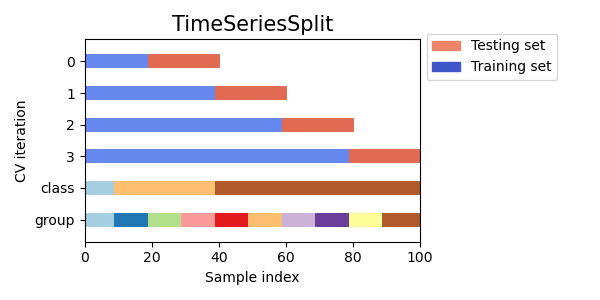
[Reference:sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

In [ ]:
n_splits = 13 # half of 26 weeks 

In [ ]:
tscv = TimeSeriesSplit(
        n_splits=n_splits,
       #gap = 24, # one days
    )

In [ ]:
scores = []
pred = []
maes = []

for i, (train_index, test_index) in enumerate(tscv.split(X,y)):

    print(f'index of train: {train_index}' )
    print(f'index of test: {test_index}' )
    print('fold : ' , i + 1, end = ' ')
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test  = y.iloc[train_index], y.iloc[test_index]

    model =  HistGradientBoostingRegressor()
   
    model.fit(X_train,y_train)
    score = model.score(X_train, y_train)
    scores.append(score)
    print(' score: ', score, end = ' ')
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    maes.append(mae)
    print(' mean_absolute_error: ', mae)
    
    preds = model.predict(test)
    pred.append(preds)
    
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors = (0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

In [ ]:
pd.DataFrame({'scores': scores,'mae':  maes,})

In [ ]:
print("score_mean =", sum(scores)/ n_splits)
print('mae_mean =',  sum(maes)/ n_splits)

* This time, I tried to change the n_splits's number, and without using Gap.
* The score is not as good as last time, but I think the graph is getting closer to the line.Right?
* update!
* I tried change the features(add and using reducing memory.)
* This time, the score got better, but public score is not good.
* I would like to try various ways, It seems to change depending on the conditions. 
* update again!
* This time , I tried HistGradientBoostingRegressor.
* more update!
* This time , I add the features.

==================================
# Submission
* I tried HistGradientBoostingRegressor,too. It was faster than RandomForestRegressor, but the results were a little larger than this.
* It may be that splitting(TimeSeriesSplit) the data with no missing data values is the right things to do.
* because,I'm concerned that train's row's number does not match the acutual total.
* *24(hr) x 3(times) x 65(rute) x (30(days) x 3(Apl,Jun,Sep) + 31(days) x 3(May,Jul,Aug))= 856440*
* train's row is 848834 + test's row is 2340(12(hr) x 3(times) x 65(rute)) = 851174
* thus, 856440 - 851174 = 5266
* Are 5266 number of data missing? I hope that this problem dosen't affect accuracy.


In [ ]:
pre = np.mean(np.column_stack(pred), axis = 1)
pre = pre.astype(int)
pre[pre < 0] = 0
pre

In [ ]:
sub.congestion = pre
#sub.to_csv('submission.csv', index=False)
#sub = pd.read_csv("submission.csv")
sub

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

sub['congestion'].plot(ax=ax, label='data')
ax.set_title('Submission\'s Congestion')

* wow! 😅
* I'm a little nervous about getting this right, but I'm looking forward to the ('Private')results!

==================================
# Forecasting
* It is a predicts future values based on past values over a given period of time.
* This prediction using previous Monday's congestion, excluding holidays.



In [ ]:
data_1 = add_holiday_info(data_1)
data_2 = add_holiday_info(data_2)

In [ ]:
data_1.time = pd.to_datetime(data_1.time)
data_1['week'] = data_1.time.dt.isocalendar().week
data_1['hour'] = data_1.time.dt.hour
data_1['dayofweek'] = data_1.time.dt.dayofweek 

data_2.time = pd.to_datetime(data_2.time)
data_2['week'] = data_2.time.dt.isocalendar().week
data_2['hour'] = data_2.time.dt.hour
data_2['dayofweek'] = data_2.time.dt.dayofweek 

In [ ]:
previous_monday_congestion = data_1[(data_1.dayofweek==0) &
                                 (data_1.hour>=12) &
                                 (data_1.is_holiday == 0) &
                                 (data_1.week==39)].congestion.to_list()


In [ ]:
#The mean of congestion of all Mondays afternoon
All_Mondays_Congestion=pd.DataFrame()

for w in range(14,39):
    All_Mondays_Congestion['week'+str(w)]=data_1[(data_1.dayofweek==0) &
                                                 (data_1.hour>=12) &
                                                 (data_1.week == w)].congestion.to_list()
    
#Mean congestion
All_Mondays_Congestion['mean'] = All_Mondays_Congestion.mean(axis=1)
#median congestion
All_Mondays_Congestion['median'] = All_Mondays_Congestion.median(axis=1)

In [ ]:
All_Mondays_Congestion = All_Mondays_Congestion.astype(int)
All_Mondays_Congestion[All_Mondays_Congestion < 0] = 0
All_Mondays_Congestion

In [ ]:
sub.congestion =All_Mondays_Congestion['median']
sub.to_csv('submission.csv', index=False)
sub = pd.read_csv("submission.csv")
sub

In [ ]:
plt.figure(figsize=(13,6))

mask=(data_1.dayofweek==0) & ( data_1.week==40)

#Plot congestion until 11:40
sns.lineplot(x = data_1[mask].hour,
             y = data_1[mask].congestion,err_style='bars',ci=None)

#Plot predictions for rest of the day
mask=(data_2.dayofweek==0) & ( data_2.week==40)

sns.lineplot(x = data_2[mask].hour,
             y = All_Mondays_Congestion['median'],
             err_style='bars',label='Mondays_Median',linestyle='--',ci=None)

sns.lineplot(x = data_2[mask].hour,
             y = All_Mondays_Congestion['mean'],
             err_style='bars',label='Mondays_Mean',linestyle='--',ci=None)

sns.lineplot(x = data_2[mask].hour,
             y = previous_monday_congestion,
             err_style='bars',label='Previous Monday',linestyle='--',ci=None)

plt.legend()
plt.title(' Predictions for 12:00 ~ 23:40, Monday, September 30',size=15)

* This graph shows congestion on previous Mondays exculding holidays.
* Does this mean that it will be more congested in the afternoon?
* update!
* I was a little curious after the deadline and checked the result.
* Unfortunately, it was the best score I've ever gotten.
* I never thought this would happen...

==================================
# Trivia time☕

* Some causes of the lack of data could be a power outage.
* It might be due to  hurricane🌀,tornadoes🌪, thumderstorms🌩 or construction🚧?
* In 1991 , there was a well-known 'the perfect storm'(Hurricane twelve : Oct 28 1991).It moved East Coast of US and caused tremendous damage.
* So I checked to find if there were any disaster during the period of this data.

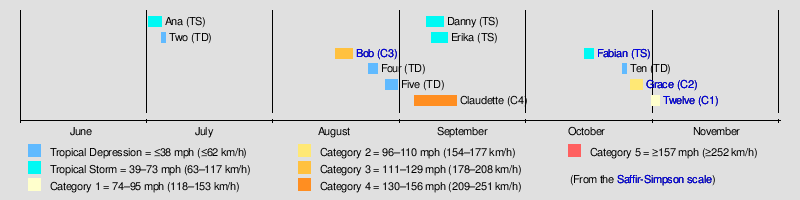
[1991 Atlantic hurricane season]
(https://en.wikipedia.org/wiki/1991_Atlantic_hurricane_season)

* On July 2 - July 5, 1991 Tropical Storm 'Ana' 
* On Aug 16 - Aug 20  1991 'Harrican Bob'
* On April 26, 1991 54 tornadoes swept across six midwestern states. 
* I wondering if something needs to be added to cover the missing data.

# Thank you all! Happy Kaggling!